# SBU CSE 352 - HW 4 - Machine Learning From Scratch


All student names in group: [Add your name]

I understand that my submission needs to be my own group's work: [all group member's initials]

I understand that ChatGPT / Copilot / other AI tools are not allowed: [all group member's initials]

---

## Instructions

Total Points: 100

1. Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy and built-in packages like random). Submit the completely rendered notebook as a HTML file.

  **Important:** Do not use scikit-learn or other packages with ML built in. The point of this is to be a learning exercise. Using linear algebra from numpy is okay (things like matrix operations or pseudoinverse, for example, but not lstsq).

2. Your notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use matplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Introduction

You will implement several machine learning algorithms and evaluate their accuracy. This will be done for a downscaled version of the MNIST digit recognition dataset.

**Like in real life, some of the tasks you will be asked to do may not be possible, at least directly. In these cases, your job is to figure out why it won't work and either propose a fix (best), or provide a clear explanation why it won't work.**

For example, if the problem says to do k-nearest neighbors with a dataset of a billion points, this could require too much time to do each classification so it's infeasible to evaluate its test accuracy. In this case, you could suggest randomly downsample the data to a more manageable size, which will speed things up by may lose some accuracy. In your answer, then, you should describe the problem and how you solved it and the trade-offs.

# Data
First the code below ensures you have access to the training data (a subset of the MNIST images), consisting of 100 handwritten images of each digit.

In [1]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/ML
!ls

C:\Users\jerry\Documents\CS\CSE 352\CSE352\HW4\CS7320-AI\ML


Cloning into 'CS7320-AI'...
'ls' is not recognized as an internal or external command,
operable program or batch file.


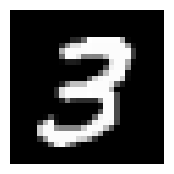

In [3]:
import matplotlib.pyplot as plt
import pickle

# if the below fails to open, then the data file is not in the current working directory (see above code block)
with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

im3 = data['images'][300] # 100 images of each digit
plt.figure(figsize=(2, 2))  # Adjust size as needed
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.show()

# Downscaling Images

MNIST images are originally 28x28. We will train our models not just on the original images, but also on downscaled images with the following sizes: 14x14, 7x7, 4x4, 2x2. The next code block shows one way to do downscaling. As you can tell from the output, we cannot expect our model's accuracy will be too high on lower resolution versions, although it's unclear how much better you can do than random chance, which should have a 10% accuracy.

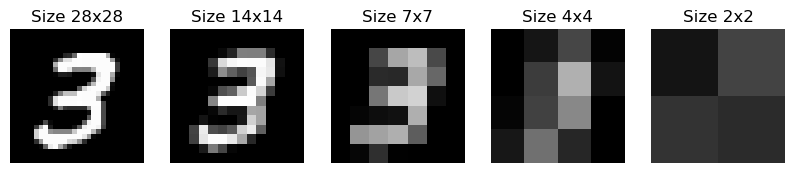

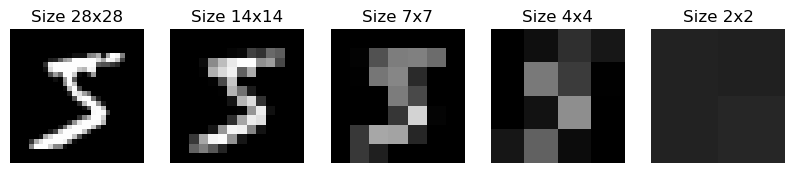

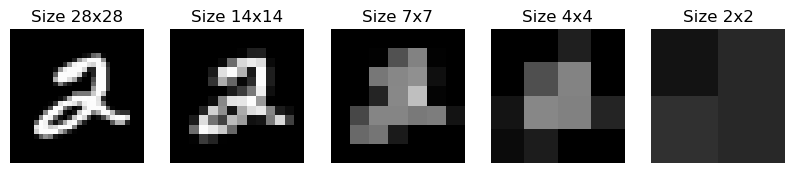

In [30]:
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels

# Select 3 "random" indices from the dataset
random_indices = [300, 500, 200]

# Downscale the images to multiple sizes and display them
sizes = [28, 14, 7, 4, 2]
for index in random_indices:
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))
    for ax, size in zip(axs, sizes):
        downscaled_image = downscale_image(images[index], size)
        ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'Size {size}x{size}')
        ax.axis('off')
    plt.show()

In [22]:
print(f'{type(data)}')
print(data['images'][200])

<class 'dict'>
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13  25 100
  122   7   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  33 151 208 252 252
  252 146   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  40 152 244 252 253 224 211
  252 232  40   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  15 152 239

---
# Tasks

Your data contains 100 images in each class. When training models, use 80% of training, 10% for validation and 10% for testing. Make sure the data is balanced in each class when splitting.

---
## Task 1: Linear Classifier [20 points]

First, implement a linear classifier. The simplest way to do this is to adapt linear regression approaches that we learned about in class, where the output is a real number. For classification, we can let one category be an output of 1.0 and the other -1.0. Then, after the classifier is trained we can use the sign of the output to determine the predicted class.

However, since in MNIST there are multiple classes (10 digits, not just 2), we need to adapt the approach further. We will try both of the following two popular strategies: One-vs-Rest (OvR) and One-vs-One (OvO).

**One-vs-Rest (OvR)** is a strategy for using binary classification algorithms for multiclass problems. In this approach, a separate binary classifier is trained for each class, which predicts whether an instance belongs to that class or not, making it the 'one' against all other classes (the 'rest'). For a new input instance, compute the output of all classifiers. The predicted class is the one whose corresponding classifier gives the highest output value.

**One-vs-One (OvO)** is another strategy where a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2 classifiers. For a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class is predicted over all binary classifications. The class with the highest count is selected as the final prediction.

### Report Results
Report the test accuracy for OvR and OvO, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2. A table may be helpful. Also report any interesting observations.

In [31]:
# Let's do One-vs rest for each classs, we need to first split into training and test sets. 

# Let's use the convention that the first 80 for each class is training, next 10 for each class is 

training_data = []
training_labels = []
dev_data=[]
dev_labels=[]
test_data = []
test_labels=[]
for i in range(0,1000,100):
    for x in range(i,i+80):
        training_data.append(data['images'][x])
        training_labels.append(data['labels'][x])
    for x in range(i+80,i+90):
        dev_data.append(data['images'][x])
        dev_labels.append(data['labels'][x])
    for x in range(i+90,i+100):
        test_data.append(data['images'][x])
        test_labels.append(data['labels'][x])

#Downscale sizes

sizes = [28,14,7,4,2]
print(dev_labels[0:21])
print()
#print(training_labels[0:5])
#print(dev_data[0:5])
#print(dev_labels[0:5])
#print(test_data[0:5])
#print(test_labels[0:5])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]



In [32]:
#Now lets define the linear regression function, which will return a vector of weights

def linearRegression(train_data, train_labels,num_steps = 1000, learning_rate=0.01):
    weights = []
    for _ in range(len(train_data[0])):
        weights.append(random.random())
        print(f'initialized weights as {weights}')
    weights = np.array(weights)
    train_data = np.array(train_data)
    train_labels = np.array(train_labels)
    
    #Gradient of Loss function = 2X_t (Xw-y)
    for _ in range(num_steps):
        left = np.dot(2,train_data.T)
        right = np.dot(train_data,weights)-train_labels
        grad = np.dot(left,right)
        weights = weights - np.dot(learning_rate,grad)
    
    return weights    

In [33]:
#Lets implment the One vs rest approach, where we train a model for each class, and each dataset is transformed to be 1 if it
# is the target, and -1 if not.

for size in sizes:
    sized_train_data = [downscale_image(row,size) for row in training_data]
    # Transform each entry from a size x size matrix to a 1 x size*size input vector for linear regression 
    vectors = []
    
    models = []
    for vector in sized_train_data:
        # We add a one term as a dummy bias term
        vec = [1]
        for i in range(len(vector)):
            for j in range(len(vector[0])):
                vec.append(vector[i][j])
        vectors.append(vec)
                
    for label in range(0,9):
        #create new label classes:
        sized_train_labels = [1 if label==x else -1 for x in training_labels]
        weights = linearRegression(vectors,sized_train_labels)
        models.append(weights)
        


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



initialized weights as [0.702734241873165, 0.4750923982190719, 0.21726043295604802, 0.46066214152441143, 0.8386002970785433, 0.1996310656970427, 0.7835656684857937, 0.09749737762873167, 0.12817968812543667, 0.7879603737716087, 0.03531778186212953, 0.8357154316722278, 0.27421623483448554, 0.7488340933786216, 0.9765970032774439, 0.6056823709378414, 0.1336102364108096, 0.182756957766657, 0.13076854684154837, 0.03258204990396374, 0.8265132423139974, 0.1923684745221962, 0.703338586982885, 0.03917227461910122, 0.20447973596343327, 0.6835911149451737, 0.09905464931615648, 0.8191758359184861, 0.22084843579810431, 0.7047403908291877, 0.7102644464926496, 0.013769330758245824, 0.8371812596481965, 0.911440320569528, 0.8730791316597252, 0.1261024092491404, 0.11258533767219259, 0.4744433196315354, 0.3117894037462301, 0.9705786953667, 0.7611725370246268, 0.37085044022627645, 0.3904404504153097, 0.41244142874585854, 0.542955720752335, 0.8421841955482209, 0.2536916227565956, 0.6110056370825592, 0.99518

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



initialized weights as [0.15700280560680613, 0.5619914853048981, 0.7991036942955596, 0.9688420709951341, 0.1564081852734429, 0.6710534632322417, 0.6121050966970402, 0.4089562255388526, 0.9138412106934626, 0.5190385227534857, 0.3083882846206091, 0.39409796637005057, 0.7605565934874408, 0.2471409132280008, 0.4063197203618014, 0.7129252337780162, 0.9374073297922821, 0.9536238610691617, 0.5933082257452935, 0.35360544149188433, 0.5458736821717931, 0.037061290227024424, 0.598064314634057, 0.4751606256302403, 0.606789475950442, 0.6808307859561482, 0.6086453981345092, 0.3065905046089209, 0.6716412626336158, 0.12400535879726671, 0.09175883057446521, 0.5413386698449997, 0.6196596111634246, 0.11869461202439036, 0.7461133537976081, 0.22066505899163014, 0.4622538353275518, 0.5256650956386982, 0.5338591202978211, 0.9863492337038852, 0.2737011898142995, 0.17930119514354925, 0.48866138461466024, 0.11519454782010152, 0.31881215608772706, 0.5276219766829219, 0.5874121897924247, 0.006216604611103627, 0.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



initialized weights as [0.8716731749554337, 0.8119016708707323, 0.08945873012211403, 0.7821602731846306, 0.646784571595864, 0.2531785573646179, 0.48578890119982865, 0.8768449259778689, 0.22496772045937707, 0.7899834760724452, 0.7091644846954905, 0.7494426853293236, 0.13985742398386813, 0.5113081209584068, 0.6287818636192403, 0.6725334241893888, 0.23050853050771025, 0.1358606559014378, 0.683641265529644, 0.5196115330329243, 0.6644911691626313, 0.08997150535045306, 0.25211264336470773, 0.7594823567206825, 0.2545058412189527, 0.7197666834014743, 0.3760700141533564, 0.877355150161017, 0.9143759919535079, 0.28318998896953185, 0.9198911895083217, 0.9938299563722008, 0.9586689277877553, 0.8810303953002554, 0.5452915277019448, 0.47659325074169523, 0.129277226674683, 0.7418773312528014, 0.7868127856862608, 0.253232526744404, 0.5853502791240762, 0.7867921057384842, 0.9411487819065146, 0.17703267086219543, 0.35635167104474785, 0.07475272924625265, 0.3507354735169542, 0.9311304698608622, 0.2162249

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



initialized weights as [0.49928113022336207, 0.5743276338496448, 0.0799066611791438, 0.7434775521139995, 0.18614539288947274, 0.3034254854912779, 0.1516233460604014, 0.48102218635405936, 0.1625717904310925, 0.9908875710787125, 0.6941962550666396, 0.1556193132819068, 0.07201059418774414, 0.7118764776772433, 0.7691743183148994, 0.14707768499357132, 0.42458763761675, 0.7290392150823294, 0.20042867739147863, 0.9318874237017835, 0.1407267372920714, 0.036751892802283526, 0.21007287553505893, 0.1772537536336416, 0.4687106821126512, 0.23639008269579254, 0.030052838790325498, 0.010050003341334435, 0.8316666849676347, 0.6757087194274574, 0.6523865406941053, 0.19923868639277864, 0.16123170846535273, 0.7832918837125131, 0.12645057691331718, 0.3902641312087458, 0.06282777345336943, 0.5108959844327795, 0.9595725836856964, 0.7356792501010162, 0.3302247036448279, 0.7285989797056742, 0.751679022417129, 0.3557414900039524, 0.12546799924984875, 0.5172782482383244, 0.17955010460414234, 0.13700329714406279

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



initialized weights as [0.1272079733555792, 0.2586997221460955, 0.2687485412121178, 0.6103549344355307, 0.8802542129407704, 0.6782699727280199, 0.4353177024229492, 0.22940415295799044, 0.03043897648486682, 0.919247603180577, 0.15622927000959863, 0.06587781528709102, 0.9066018210122045, 0.2201952220225698, 0.18098901730353656, 0.33492336447556237, 0.2909033544423322, 0.9777414085984276, 0.8956822336793867, 0.799954819763161, 0.909883045910405, 0.03252121982960876, 0.6865334401775194, 0.30071905092730955, 0.5094484964564895, 0.9604793660560176, 0.02736085332666849, 0.3173214136776371, 0.7535047015849187, 0.11835231598718443, 0.8046407953073139, 0.7771084605429791, 0.3393795281771479, 0.737792848424384, 0.9841960637771516, 0.9655726014759798, 0.5665271037913608, 0.11565138909131067, 0.2764925425546845, 0.4848831276808063, 0.8471966279646014, 0.9001692547449559, 0.3898596765058555, 0.6150062920465649, 0.22043947907836936, 0.8557492688099761, 0.9044210182968698, 0.490795404808018, 0.0222857

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



initialized weights as [0.9713076062954065]
initialized weights as [0.9713076062954065, 0.30974297225426073]
initialized weights as [0.9713076062954065, 0.30974297225426073, 0.6687575258227079]
initialized weights as [0.9713076062954065, 0.30974297225426073, 0.6687575258227079, 0.9763003077212347]
initialized weights as [0.9713076062954065, 0.30974297225426073, 0.6687575258227079, 0.9763003077212347, 0.3170654967246953]
initialized weights as [0.9713076062954065, 0.30974297225426073, 0.6687575258227079, 0.9763003077212347, 0.3170654967246953, 0.28820328364143155]
initialized weights as [0.9713076062954065, 0.30974297225426073, 0.6687575258227079, 0.9763003077212347, 0.3170654967246953, 0.28820328364143155, 0.23899408800761424]
initialized weights as [0.9713076062954065, 0.30974297225426073, 0.6687575258227079, 0.9763003077212347, 0.3170654967246953, 0.28820328364143155, 0.23899408800761424, 0.4599136045527106]
initialized weights as [0.9713076062954065, 0.30974297225426073, 0.668757525

initialized weights as [0.5896876917210931]
initialized weights as [0.5896876917210931, 0.1450303609926311]
initialized weights as [0.5896876917210931, 0.1450303609926311, 0.15010326945150176]
initialized weights as [0.5896876917210931, 0.1450303609926311, 0.15010326945150176, 0.35700590886252326]
initialized weights as [0.5896876917210931, 0.1450303609926311, 0.15010326945150176, 0.35700590886252326, 0.4363946055587764]
initialized weights as [0.5896876917210931, 0.1450303609926311, 0.15010326945150176, 0.35700590886252326, 0.4363946055587764, 0.6765931282799356]
initialized weights as [0.5896876917210931, 0.1450303609926311, 0.15010326945150176, 0.35700590886252326, 0.4363946055587764, 0.6765931282799356, 0.07029324833372408]
initialized weights as [0.5896876917210931, 0.1450303609926311, 0.15010326945150176, 0.35700590886252326, 0.4363946055587764, 0.6765931282799356, 0.07029324833372408, 0.5192922909798757]
initialized weights as [0.5896876917210931, 0.1450303609926311, 0.150103269

initialized weights as [0.5074908417396007]
initialized weights as [0.5074908417396007, 0.23630005826000933]
initialized weights as [0.5074908417396007, 0.23630005826000933, 0.9410030214625271]
initialized weights as [0.5074908417396007, 0.23630005826000933, 0.9410030214625271, 0.855003043477443]
initialized weights as [0.5074908417396007, 0.23630005826000933, 0.9410030214625271, 0.855003043477443, 0.2596582345543825]
initialized weights as [0.5074908417396007, 0.23630005826000933, 0.9410030214625271, 0.855003043477443, 0.2596582345543825, 0.8799115263552769]
initialized weights as [0.5074908417396007, 0.23630005826000933, 0.9410030214625271, 0.855003043477443, 0.2596582345543825, 0.8799115263552769, 0.3883203470054051]
initialized weights as [0.5074908417396007, 0.23630005826000933, 0.9410030214625271, 0.855003043477443, 0.2596582345543825, 0.8799115263552769, 0.3883203470054051, 0.5078131913557196]
initialized weights as [0.5074908417396007, 0.23630005826000933, 0.9410030214625271, 0

initialized weights as [0.8840448874453253]
initialized weights as [0.8840448874453253, 0.5756575674838457]
initialized weights as [0.8840448874453253, 0.5756575674838457, 0.07253440445824066]
initialized weights as [0.8840448874453253, 0.5756575674838457, 0.07253440445824066, 0.16563999431273357]
initialized weights as [0.8840448874453253, 0.5756575674838457, 0.07253440445824066, 0.16563999431273357, 0.03885375128334634]
initialized weights as [0.8840448874453253, 0.5756575674838457, 0.07253440445824066, 0.16563999431273357, 0.03885375128334634, 0.8975015166484427]
initialized weights as [0.8840448874453253, 0.5756575674838457, 0.07253440445824066, 0.16563999431273357, 0.03885375128334634, 0.8975015166484427, 0.27565846865672683]
initialized weights as [0.8840448874453253, 0.5756575674838457, 0.07253440445824066, 0.16563999431273357, 0.03885375128334634, 0.8975015166484427, 0.27565846865672683, 0.17271115419382588]
initialized weights as [0.8840448874453253, 0.5756575674838457, 0.0725

initialized weights as [0.02203492118852879]
initialized weights as [0.02203492118852879, 0.7106382557534535]
initialized weights as [0.02203492118852879, 0.7106382557534535, 0.5974181866745387]
initialized weights as [0.02203492118852879, 0.7106382557534535, 0.5974181866745387, 0.3256491284898898]
initialized weights as [0.02203492118852879, 0.7106382557534535, 0.5974181866745387, 0.3256491284898898, 0.07338197315143402]
initialized weights as [0.02203492118852879, 0.7106382557534535, 0.5974181866745387, 0.3256491284898898, 0.07338197315143402, 0.8926997724873861]
initialized weights as [0.02203492118852879, 0.7106382557534535, 0.5974181866745387, 0.3256491284898898, 0.07338197315143402, 0.8926997724873861, 0.4692840036203937]
initialized weights as [0.02203492118852879, 0.7106382557534535, 0.5974181866745387, 0.3256491284898898, 0.07338197315143402, 0.8926997724873861, 0.4692840036203937, 0.9279517565773236]
initialized weights as [0.02203492118852879, 0.7106382557534535, 0.597418186

initialized weights as [0.8450749319826781]
initialized weights as [0.8450749319826781, 0.7036506598096066]
initialized weights as [0.8450749319826781, 0.7036506598096066, 0.47047500782611895]
initialized weights as [0.8450749319826781, 0.7036506598096066, 0.47047500782611895, 0.2459975619433834]
initialized weights as [0.8450749319826781, 0.7036506598096066, 0.47047500782611895, 0.2459975619433834, 0.3450207226185038]
initialized weights as [0.8450749319826781, 0.7036506598096066, 0.47047500782611895, 0.2459975619433834, 0.3450207226185038, 0.6586534679483319]
initialized weights as [0.8450749319826781, 0.7036506598096066, 0.47047500782611895, 0.2459975619433834, 0.3450207226185038, 0.6586534679483319, 0.1412236976124619]
initialized weights as [0.8450749319826781, 0.7036506598096066, 0.47047500782611895, 0.2459975619433834, 0.3450207226185038, 0.6586534679483319, 0.1412236976124619, 0.41026369026763476]
initialized weights as [0.8450749319826781, 0.7036506598096066, 0.470475007826118

initialized weights as [0.6808445405505519]
initialized weights as [0.6808445405505519, 0.15442581614267803]
initialized weights as [0.6808445405505519, 0.15442581614267803, 0.9135200434457881]
initialized weights as [0.6808445405505519, 0.15442581614267803, 0.9135200434457881, 0.40172337962751836]
initialized weights as [0.6808445405505519, 0.15442581614267803, 0.9135200434457881, 0.40172337962751836, 0.9586241895999126]
initialized weights as [0.6808445405505519, 0.15442581614267803, 0.9135200434457881, 0.40172337962751836, 0.9586241895999126, 0.4478045145269043]
initialized weights as [0.6808445405505519, 0.15442581614267803, 0.9135200434457881, 0.40172337962751836, 0.9586241895999126, 0.4478045145269043, 0.47518178389147436]
initialized weights as [0.6808445405505519, 0.15442581614267803, 0.9135200434457881, 0.40172337962751836, 0.9586241895999126, 0.4478045145269043, 0.47518178389147436, 0.40401418427850544]
initialized weights as [0.6808445405505519, 0.15442581614267803, 0.913520

initialized weights as [0.8828554463331405]
initialized weights as [0.8828554463331405, 0.6399039482453206]
initialized weights as [0.8828554463331405, 0.6399039482453206, 0.334449011092835]
initialized weights as [0.8828554463331405, 0.6399039482453206, 0.334449011092835, 0.652069234180369]
initialized weights as [0.8828554463331405, 0.6399039482453206, 0.334449011092835, 0.652069234180369, 0.4099679786784348]
initialized weights as [0.8828554463331405, 0.6399039482453206, 0.334449011092835, 0.652069234180369, 0.4099679786784348, 0.3752365669074712]
initialized weights as [0.8828554463331405, 0.6399039482453206, 0.334449011092835, 0.652069234180369, 0.4099679786784348, 0.3752365669074712, 0.037383392153322204]
initialized weights as [0.8828554463331405, 0.6399039482453206, 0.334449011092835, 0.652069234180369, 0.4099679786784348, 0.3752365669074712, 0.037383392153322204, 0.2786271493671548]
initialized weights as [0.8828554463331405, 0.6399039482453206, 0.334449011092835, 0.6520692341

initialized weights as [0.7402782302320402]
initialized weights as [0.7402782302320402, 0.3964203395885232]
initialized weights as [0.7402782302320402, 0.3964203395885232, 0.8191671884636758]
initialized weights as [0.7402782302320402, 0.3964203395885232, 0.8191671884636758, 0.8037319999937504]
initialized weights as [0.7402782302320402, 0.3964203395885232, 0.8191671884636758, 0.8037319999937504, 0.020906211607096492]
initialized weights as [0.7402782302320402, 0.3964203395885232, 0.8191671884636758, 0.8037319999937504, 0.020906211607096492, 0.06480607139299588]
initialized weights as [0.7402782302320402, 0.3964203395885232, 0.8191671884636758, 0.8037319999937504, 0.020906211607096492, 0.06480607139299588, 0.8252023116384097]
initialized weights as [0.7402782302320402, 0.3964203395885232, 0.8191671884636758, 0.8037319999937504, 0.020906211607096492, 0.06480607139299588, 0.8252023116384097, 0.448413934884367]
initialized weights as [0.7402782302320402, 0.3964203395885232, 0.819167188463

initialized weights as [0.24040347715691868]
initialized weights as [0.24040347715691868, 0.4864700465772185]
initialized weights as [0.24040347715691868, 0.4864700465772185, 0.47319692329647856]
initialized weights as [0.24040347715691868, 0.4864700465772185, 0.47319692329647856, 0.39935787016831925]
initialized weights as [0.24040347715691868, 0.4864700465772185, 0.47319692329647856, 0.39935787016831925, 0.4483255038880496]
initialized weights as [0.24040347715691868, 0.4864700465772185, 0.47319692329647856, 0.39935787016831925, 0.4483255038880496, 0.6814550384113232]
initialized weights as [0.24040347715691868, 0.4864700465772185, 0.47319692329647856, 0.39935787016831925, 0.4483255038880496, 0.6814550384113232, 0.4428402354380595]
initialized weights as [0.24040347715691868, 0.4864700465772185, 0.47319692329647856, 0.39935787016831925, 0.4483255038880496, 0.6814550384113232, 0.4428402354380595, 0.6059997262419027]
initialized weights as [0.24040347715691868, 0.4864700465772185, 0.47

initialized weights as [0.33047357651832643]
initialized weights as [0.33047357651832643, 0.6617687455172309]
initialized weights as [0.33047357651832643, 0.6617687455172309, 0.9514117221507349]
initialized weights as [0.33047357651832643, 0.6617687455172309, 0.9514117221507349, 0.49549100081861264]
initialized weights as [0.33047357651832643, 0.6617687455172309, 0.9514117221507349, 0.49549100081861264, 0.2774567351131707]
initialized weights as [0.33047357651832643, 0.6617687455172309, 0.9514117221507349, 0.49549100081861264, 0.2774567351131707, 0.3089291764180311]
initialized weights as [0.33047357651832643, 0.6617687455172309, 0.9514117221507349, 0.49549100081861264, 0.2774567351131707, 0.3089291764180311, 0.5065574376430423]
initialized weights as [0.33047357651832643, 0.6617687455172309, 0.9514117221507349, 0.49549100081861264, 0.2774567351131707, 0.3089291764180311, 0.5065574376430423, 0.4194518604730654]
initialized weights as [0.33047357651832643, 0.6617687455172309, 0.95141172

initialized weights as [0.017588274378559587]
initialized weights as [0.017588274378559587, 0.35754409442058477]
initialized weights as [0.017588274378559587, 0.35754409442058477, 0.7239599247660397]
initialized weights as [0.017588274378559587, 0.35754409442058477, 0.7239599247660397, 0.837641327280824]
initialized weights as [0.017588274378559587, 0.35754409442058477, 0.7239599247660397, 0.837641327280824, 0.9403703570167797]
initialized weights as [0.017588274378559587, 0.35754409442058477, 0.7239599247660397, 0.837641327280824, 0.9403703570167797, 0.47046327678529887]
initialized weights as [0.017588274378559587, 0.35754409442058477, 0.7239599247660397, 0.837641327280824, 0.9403703570167797, 0.47046327678529887, 0.39804387789930573]
initialized weights as [0.017588274378559587, 0.35754409442058477, 0.7239599247660397, 0.837641327280824, 0.9403703570167797, 0.47046327678529887, 0.39804387789930573, 0.595230753000048]
initialized weights as [0.017588274378559587, 0.35754409442058477,

initialized weights as [0.19448067999830965]
initialized weights as [0.19448067999830965, 0.0544882056968784]
initialized weights as [0.19448067999830965, 0.0544882056968784, 0.3289388370028773]
initialized weights as [0.19448067999830965, 0.0544882056968784, 0.3289388370028773, 0.3125856241970635]
initialized weights as [0.19448067999830965, 0.0544882056968784, 0.3289388370028773, 0.3125856241970635, 0.2273527590692851]
initialized weights as [0.19448067999830965, 0.0544882056968784, 0.3289388370028773, 0.3125856241970635, 0.2273527590692851, 0.1682984160117449]
initialized weights as [0.19448067999830965, 0.0544882056968784, 0.3289388370028773, 0.3125856241970635, 0.2273527590692851, 0.1682984160117449, 0.5770504617875534]
initialized weights as [0.19448067999830965, 0.0544882056968784, 0.3289388370028773, 0.3125856241970635, 0.2273527590692851, 0.1682984160117449, 0.5770504617875534, 0.9135036744855847]
initialized weights as [0.19448067999830965, 0.0544882056968784, 0.3289388370028

initialized weights as [0.9572447683047027]
initialized weights as [0.9572447683047027, 0.8421179782781776]
initialized weights as [0.9572447683047027, 0.8421179782781776, 0.7304245096432521]
initialized weights as [0.9572447683047027, 0.8421179782781776, 0.7304245096432521, 0.6698897470120725]
initialized weights as [0.9572447683047027, 0.8421179782781776, 0.7304245096432521, 0.6698897470120725, 0.14765971598412309]
initialized weights as [0.9572447683047027, 0.8421179782781776, 0.7304245096432521, 0.6698897470120725, 0.14765971598412309, 0.10849279397549683]
initialized weights as [0.9572447683047027, 0.8421179782781776, 0.7304245096432521, 0.6698897470120725, 0.14765971598412309, 0.10849279397549683, 0.6559372017756993]
initialized weights as [0.9572447683047027, 0.8421179782781776, 0.7304245096432521, 0.6698897470120725, 0.14765971598412309, 0.10849279397549683, 0.6559372017756993, 0.7924515215295358]
initialized weights as [0.9572447683047027, 0.8421179782781776, 0.730424509643252

initialized weights as [0.6866694669522181]
initialized weights as [0.6866694669522181, 0.8317389170339908]
initialized weights as [0.6866694669522181, 0.8317389170339908, 0.6303991536181027]
initialized weights as [0.6866694669522181, 0.8317389170339908, 0.6303991536181027, 0.461168025140799]
initialized weights as [0.6866694669522181, 0.8317389170339908, 0.6303991536181027, 0.461168025140799, 0.8773572560662062]
initialized weights as [0.008729362469454993]
initialized weights as [0.008729362469454993, 0.92462381391761]
initialized weights as [0.008729362469454993, 0.92462381391761, 0.36039599805501177]
initialized weights as [0.008729362469454993, 0.92462381391761, 0.36039599805501177, 0.42504744468518185]
initialized weights as [0.008729362469454993, 0.92462381391761, 0.36039599805501177, 0.42504744468518185, 0.8534585132736714]
initialized weights as [0.20383515253954088]
initialized weights as [0.20383515253954088, 0.9837426858641994]
initialized weights as [0.20383515253954088, 

---
## Task 2: Data Augmentation [20 points]

Your boss was unhappy with the test accuracy, especially of your 2x2 image classifier, and has made some suggestions. The problem, according to your boss, is that there is not enough data in each input $x$. You are told to augment the data with derived features in order to help the classifier.

Specifically, given an input $x$, create additional attributes by computing all of the data up to powers of two. For example, in the 2x2 case your example $x$ consists of four pixel values $x_0$, $x_1$, $x_2$, and $x_3$. Your new input data would have:

* all power of zero: 1 (constant)
* all powers of one: $x_0$, $x_1$, $x_2$, $x_3$
* all powers of two:

  $x_0^2$, $x_0 x_1$, $x_0 x_2$, $x_0 x_3$,
  
  $x_1^2$, $x_1 x_2$, $ x_1 x_3$,
  
  $x_2^2$, $x_2 x_3$,
  
  $x_3^2$

The data would have 15 values, which has the potential to learn nonlinear relationships between the original inputs, which was not possible before.

### Report Results

Report the test accuracy for OvR only, with the data augmentation approach, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2 (again, perhaps incorporating a table). Report any interesting results or observations.

Also, explain to your boss what the danger is of looking at a model's final test accuracy and then suggesting changes to improve it. What should be done instead, if you know you will consider different types of models or hyperparameters in the same model class?

In [ ]:
# Your answer goes here

---
## Task 3: k-Nearest Neighbors Classifier [20 points]

Your boss is still unhappy with the results (and still ignoring your advice about not using test data accuracy for model decisions).

Next, you are to use the k-nearest neighbors approach to build a classifier for our data. Since we have multiple classes, the one that gets selected can be based on a plurality vote of the $k$ closest samples (whichever category is most frequent). If there are ties, select the class based on the sum of the distances from the test point. For example, if $k=5$, and the closest 5 samples have two pictures that are from category "1" and two pictures that are from category "7", then you choose the output by computing the sum of the distance from the test point and the two "5" samples, as well as the sum of distances from the test point to the two "7" samples, and then outputting the class with the smaller total distance.

### Report Results

For each image size, exhaustively explore different values of $k$ up to 50. Report the best test accuracy. Report the average time taken to do a lookup with the model.

In [ ]:
# Your answer goes here

---
## Task 4: Neural Networks [40 Points]

Next, your boss wants you to try neural networks. Rather than using a library for everything, you will **only** use `pytorch` to perform backpropagation and compute gradients. You can write your own neural network class if desired, don't use anything from `pytorch` for that.


An example network and how to compute gradients with pytorch is shown below.


In [ ]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This is followed by a sigmoid
#    activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2) for linear transformation,
#    followed by a softmax activation function. The softmax activation is used here to normalize the
#    output of the second layer into a probability distribution over the three classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should not
# be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())


Initial Output: tensor([0.5348, 0.2167, 0.2485], grad_fn=<SoftmaxBackward0>)
Desired Output: tensor([1., 0., 0.])
Initial loss: 0.625852644443512
Gradient for weights matrix W1: tensor([[-2.9431e-03, -5.8862e-03, -8.8293e-03],
        [ 4.1993e-03,  8.3986e-03,  1.2598e-02],
        [-3.0524e-06, -6.1048e-06, -9.1572e-06]])
New loss after updating weights and biases: 0.6079817414283752


The code above updates the parameters based on a single piece of data, but often multiple inputs are used and their gradient is averaged when updating a model.

Your task is to write the training code for the different neural network architectures proposed and report accuracy. Start with all random parameters between -1 and 1. Training should stop when the accuracy, as measured on the validation data, no longer appears to be improving. You can plot the validation data accuracy over time to ensure this looks correct. If this takes too long but it appears the model is still improving in accuracy, consider increasing the learning rate (start with 0.02 as in the example).

For the gradient, you are to compute the gradient over the full set of training data, and then average them together before you update. Then, repeat with mini-batches of size 100, with 10 random samples from each class. This should update the model weights faster, but may require more updates to get the accuracy down.

### Report Results

Provide at least one plot of your validation data accuracy going down over time as training progresses. What was the condition you decided to use to detect if training should stop? How many updates were needed in the case of your plot?


Create a table where each row corresponds to one model and training method (mini-batch or full). Use the 7x7 version of the data (49-dimensional inputs). You are to explore the following models: the number of hidden layers can be varied between 2 and 4. Each layer's size can be 16, 32, or 64 neurons (all hidden layers have the same number of neurons). Explore three different activation functions for the network, ReLU (`torch.relu`), arctan (`torch.atan`), and sigmoid (`torch.sigmoid`). After the final layer, use a softmax rather than the normal network activation function, to ensure all outputs are between 0 and 1. There should be 10 outputs, one for each class in the MNIST data.

In the table, report the architecture, training time, number of model updates and test accuracy. What is the best architecture? Did mini-batches help with anything? Report any other interesting observations.



In [ ]:
# Write your code here